<a id='step1'></a>
# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


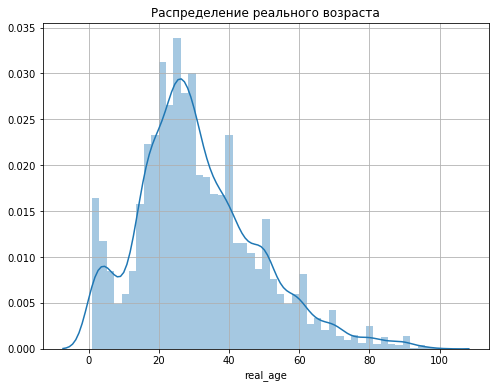

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Распределение реального возраста')
ax.grid(True)
sns.distplot(df['real_age'])

На графике распределение возрастов вполне соответствует распределениям возрастов, предоставляемых различными международными организациями, которое удалось обнаружить в сети Интернет.

Видна небольшая бимодальность. Скорее всего, замешана ещё одна выборка в данных, есть некий признак, который делает гарфик двугорбым. Т.е. выборка была взята не случайна, а формировалась.

Отобразим несколько фотографий для изучения.

In [12]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255
    )

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=127)

Found 5694 validated image filenames.


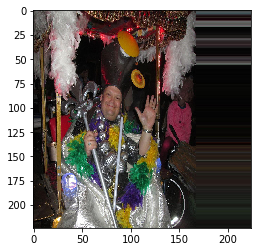

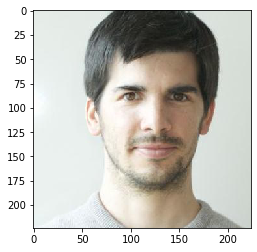

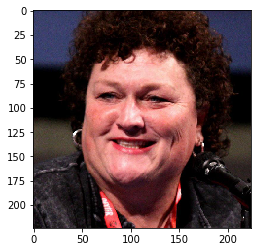

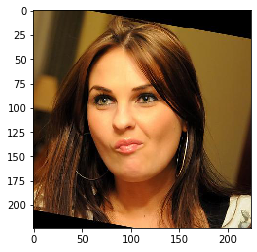

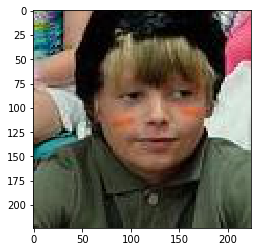

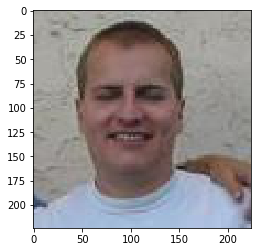

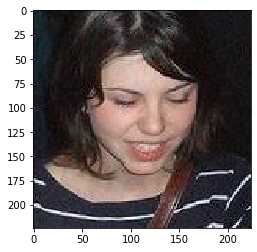

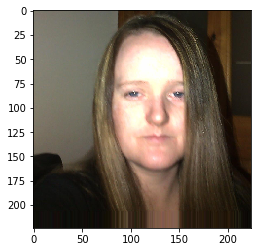

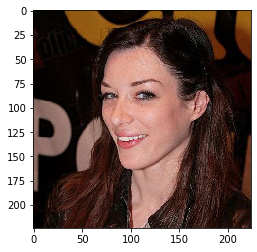

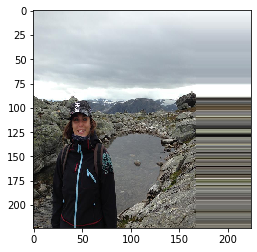

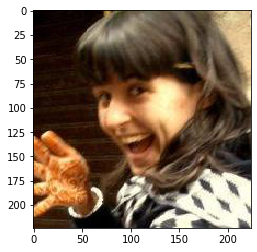

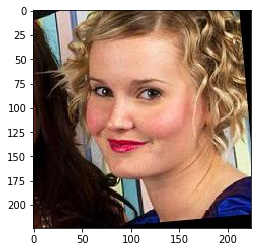

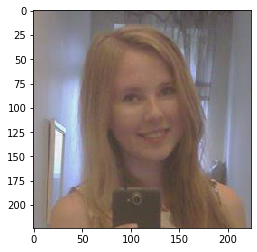

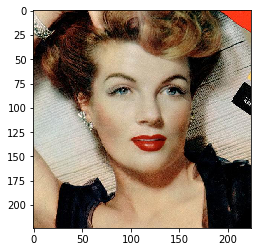

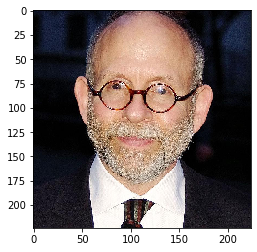

In [13]:
for i in range(15):
    image, label = next(train_datagen_flow)
    plt.imshow(image[i])
    plt.show() 

### Выводы

Наш датасет содержит 7591 изображение лиц людей различного возраста (от 1 года до 100 лет). 

Отметим ряд особенностей изображений:
- некоторые изображения уже имеют поворот, однако он используется, чтобы сделать лица вертикальными;
- в датасете есть как цветные, так и черно-белые фотографии;
- в датасете есть фотогарафи, на которых лица изображены в полупрофиль;
- в датасете есть фотогарафи с разным разрешением;
- в датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью)
- различаются яркость и контрастность, цветовая температура.

<a href='#start'>К содержанию</a>

<a id='step2'></a>
# 2. Обучение модели

В качестве основы для решения нашей задачи была выбрана архитектура `ResNet` с 50 слоями.

Для адаптации под нашу задачу не включим в нашу сеть верхушку сети `ResNet`, но добавим слой пулинга и один полносвязный с функцией активации `ReLU`.

Никаких дополнительных аугментаций к датасету применять не будем.

In [ ]:
def load_test(path):
    df = pd.read_csv(path+'/labels.csv')
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=127) 
    return val_datagen_flow


def load_train(path):
    df = pd.read_csv(path+'/labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
        )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=127)
    return train_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='imagenet') 
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu')) 

    optimizer = Adam(lr=0.0001) 
    model.compile(optimizer=optimizer, loss='mse', 
              metrics=['mae'])
 

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5, 
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)                
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 139s - loss: 211.3692 - mae: 10.5530 - val_loss: 633.0632 - val_mae: 19.9905
Epoch 2/5
356/356 - 44s - loss: 69.4454 - mae: 6.3222 - val_loss: 217.9412 - val_mae: 11.3138
Epoch 3/5
356/356 - 44s - loss: 38.7154 - mae: 4.8297 - val_loss: 78.2189 - val_mae: 6.7011
Epoch 4/5
356/356 - 44s - loss: 25.3665 - mae: 3.8960 - val_loss: 80.2790 - val_mae: 6.7311
Epoch 5/5
356/356 - 44s - loss: 16.5370 - mae: 3.1388 - val_loss: 77.1491 - val_mae: 6.5994
119/119 - 11s - loss: 77.1491 - mae: 6.5994
Test MAE: 6.5994
```

### Выводы 

Наша модель обучилась за 5 эпох, получив итоговую метрику на валидационной выборке `MAE = 6.5994`.

<a href='#start'>К содержанию</a>

<a id='step3'></a>
# 3. Анализ обученной модели

В данной работе мы подобрали подходящую для решения задачи определения возраста человека по фотографии архитектуру сети.

Итоговая метрика `MAE` на валидационной выборке оказалась равна `6.5994`. Несмотря на переобучение сети (MAE при обучении достигло значения `3.1388`, установленный заданием порог в `MAE = 8` был преодолен, а значит полученная нами модель может успешно решать задачу определения возраста с необходимой точностью.

<a href='#start'>К содержанию</a>